In [1]:
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer.reparam import TransformReparam, LocScaleReparam
from numpyro.distributions.transforms import AffineTransform
from numpyro.infer import MCMC, NUTS, Predictive, SVI, Trace_ELBO, log_likelihood
from numpyro.infer.autoguide import AutoLaplaceApproximation
import numpyro.optim as optim
from numpyro import handlers
from numpyro.handlers import mask
import jax
from jax.numpy import DeviceArray
import jax.numpy as jnp
from jax import random, lax
from jax import nn as jnn
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '
/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/jax/experimental/stax.py:28: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  warnings.warn('jax.experimental.stax is deprecated, '


In [16]:
d = pd.read_csv("data/rugged.csv", sep=";")
d["log_gdp"] = np.log(d["rgdppc_2000"])
dd = d[d.log_gdp.notna()]
dd.loc[:,"log_gdp_std"] = dd.log_gdp / dd.log_gdp.mean()
dd.loc[:,"rugged_std"] = dd.rugged / dd.rugged.max()
dd.loc[:,"cid"] = np.where(dd.cont_africa == 1, 0, 1)

/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [17]:
dd.sample(10).T

,37,160,182,137,14,47,2,42,126,34
isocode,CHL,PAK,SEN,MNG,AZE,CRI,AGO,COG,MAR,CAN
isonum,152,586,686,496,31,188,24,178,504,124
country,Chile,Pakistan,Senegal,Mongolia,Azerbaijan,Costa Rica,Angola,Congo,Morocco,Canada
rugged,2.481,1.949,0.244,1.057,1.672,2.112,0.858,0.152,2.413,0.775
rugged_popw,0.677,0.341,0.246,0.765,0.534,1.044,0.714,0.411,1.291,0.37
rugged_slope,7.365,5.665,0.647,3.352,5.08,5.708,2.274,0.406,6.853,2.695
rugged_lsd,0.731,0.559,0.065,0.309,0.49,0.623,0.228,0.049,0.629,0.23
rugged_pc,38.199,25.078,0.168,12.623,27.713,36.61,4.906,0.243,36.083,9.122
land_area,74880.0,77088.0,19253.0,156650.0,8260.5,5106.0,124670.0,34150.0,44630.0,909351.0
lat,-37.937,29.97,14.361,46.836,40.288,9.969,-12.299,-0.831,31.882,61.495


In [25]:
def model(cid, rugged_std, log_gdp_std=None):
    a = numpyro.sample("a", dist.Normal(1, 0.1).expand([2]))
    b = numpyro.sample("b", dist.Normal(0, 0.3).expand([2]))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    #mu = numpyro.deterministic("mu", a[cid] + b[cid] * (rugged_std - 0.215))
    mu = a[cid] + b[cid] * (rugged_std - 0.215)
    numpyro.sample("log_gdp_std", dist.Normal(mu, sigma), obs=log_gdp_std)


m8_3 = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m8_3,
    optim.Adam(0.1),
    Trace_ELBO(),
    cid=dd.cid.values,
    rugged_std=dd.rugged_std.values,
    log_gdp_std=dd.log_gdp_std.values,
)
svi_result = svi.run(random.PRNGKey(0), 1000)
p8_3 = svi_result.params
post = m8_3.sample_posterior(random.PRNGKey(1), p8_3, (1000,))
numpyro.diagnostics.print_summary({k: v for k, v in post.items() if k != "mu"}, 0.89, False)

100%|██████████| 1000/1000 [00:02<00:00, 459.27it/s, init loss: 1670.7775, avg. loss [951-1000]: -134.7926]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]      0.89      0.02      0.89      0.86      0.91   1009.20      1.00
      a[1]      1.05      0.01      1.05      1.04      1.07    755.33      1.00
      b[0]      0.13      0.07      0.13      0.01      0.24   1045.06      1.00
      b[1]     -0.15      0.06     -0.14     -0.23     -0.05   1003.36      1.00
     sigma      0.11      0.01      0.11      0.10      0.12    810.01      1.00



In [26]:
m9_1 = MCMC(NUTS(model), num_warmup=2000, num_samples=10000)
m9_1.run(random.PRNGKey(42), cid=dd.cid.values, rugged_std=dd.rugged_std.values,log_gdp_std=dd.log_gdp_std.values)
m9_1.print_summary()

sample: 100%|██████████| 12000/12000 [00:07<00:00, 1539.83it/s, 7 steps of size 6.81e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      a[0]      0.89      0.02      0.89      0.86      0.91  13229.07      1.00
      a[1]      1.05      0.01      1.05      1.03      1.07  12644.89      1.00
      b[0]      0.13      0.08      0.13      0.01      0.26  13299.04      1.00
      b[1]     -0.14      0.06     -0.14     -0.23     -0.05  13417.43      1.00
     sigma      0.11      0.01      0.11      0.10      0.12  12070.94      1.00

Number of divergences: 0


In [27]:
m9_1 = MCMC(NUTS(model), num_warmup=2000, num_samples=10000, num_chains=4)
m9_1.run(random.PRNGKey(42), cid=dd.cid.values, rugged_std=dd.rugged_std.values,log_gdp_std=dd.log_gdp_std.values)
m9_1.print_summary()

/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/numpyro/infer/mcmc.py:274: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|██████████| 12000/12000 [00:02<00:00, 4713.53it/s, 7 steps of size 7.35e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      a[0]      0.89      0.02      0.89      0.86      0.91  47102.28      1.00
      a[1]      1.05      0.01      1.05      1.03      1.07  49235.38      1.00
      b[0]      0.13      0.08      0.13      0.01      0.26  48275.91      1.00
      b[1]     -0.14      0.06     -0.14     -0.24     -0.05  49955.32      1.00
     sigma      0.11      0.01      0.11      0.10      0.12  45411.90      1.00

Number of divergences: 0


In [21]:
jax.local_device_count()

1

In [28]:
az9_1 = az.from_numpyro(m9_1)

In [29]:
az9_1

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

array([[<AxesSubplot:ylabel='a\n0'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='a\n1'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='b\n0'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='b\n1'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='a\n0', ylabel='sigma'>,
        <AxesSubplot:xlabel='a\n1'>, <AxesSubplot:xlabel='b\n0'>,
        <AxesSubplot:xlabel='b\n1'>, <AxesSubplot:xlabel='sigma'>]],
      dtype=object)

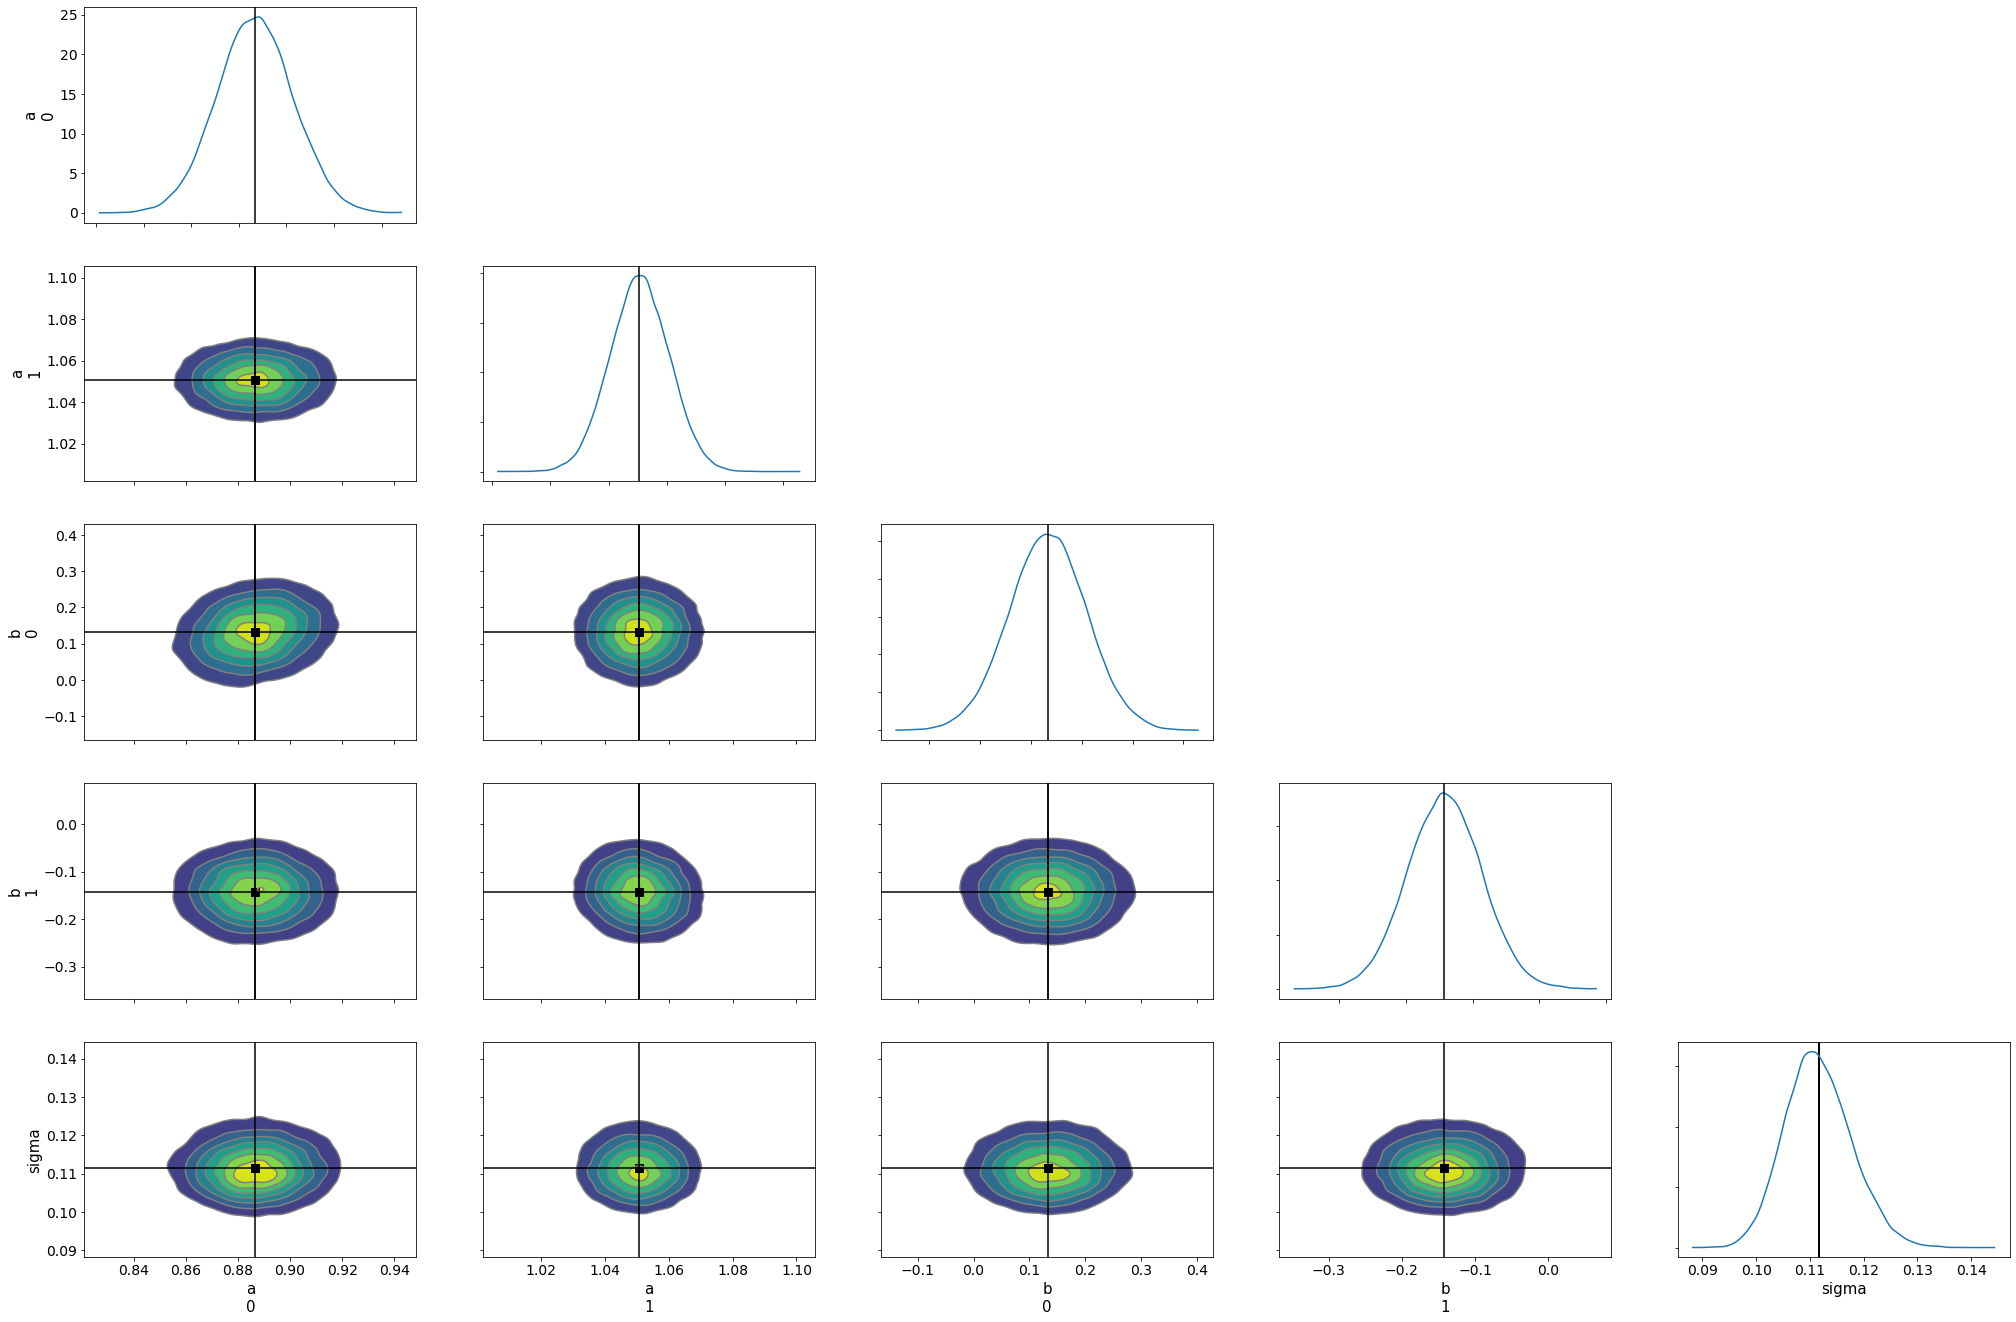

In [31]:
az.plot_pair(az9_1, marginals=True, kind='kde', point_estimate='mean')